In [1]:
from scipy.spatial.distance import cdist
from collections import Counter
from keras.models import Model, Sequential
from keras import layers
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

## Data Preprocessing

In [2]:
# GPU:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
import torchaudio

Looking in links: https://download.pytorch.org/whl/torch_stable.html


/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
from torchaudio.datasets import SPEECHCOMMANDS

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        path_of_dataset = "./"
        super().__init__(path_of_dataset, download=True)
        self._path = path_of_dataset + 'SpeechCommands/speech_commands_v0.02'

        def load_list(filename):
            print(self._path)
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# Create training and testing split of the data. We do not use validation.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]


./SpeechCommands/speech_commands_v0.02
./SpeechCommands/speech_commands_v0.02
./SpeechCommands/speech_commands_v0.02


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
print("Length of train set:",len(train_set))
print("Length of test set:",len(test_set))

Length of train set: 84843
Length of test set: 11005


In [ ]:
train_set[0]

(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]),
 16000,
 'backward',
 '0165e0e8',
 0)

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


16000

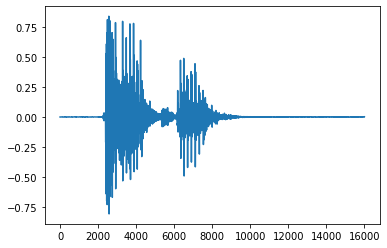

In [ ]:
waveform1, sample_rate, label, speaker_id1, utterance_number = train_set[1]
print("Shape of waveform: {}".format(waveform1.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform1.t().numpy());
speaker_id
waveform1.shape[1]

In [ ]:
classes = []
for i in range(5000):
  datapoint = train_set[i]
  if datapoint[3] not in classes:
      classes.append(datapoint[3])
print(classes)
print(len(classes))

['0165e0e8', '017c4098', '02ade946', '042a8dde', '050170cb', '0585b66d', '06f6c194', '08ab231c', '0a2b400e', '0a396ff2', '0a5636ca', '0b7ee1a0', '0ba018fc', '0d6d7360', '0d85a428', '0d90d8e1', '0e6e36c9', '0e8ec1cb', '0f46028a', '0f7266cf', '113b3fbc', '131e738d', '13a93b33', '13dce503', '1474273a', '1496195a', '14c7b073', '1589451d', '15dd287d', '18d84076', '18e910f4', '18ffa72d', '195c120a', '1970b130', '19a1e5c7', '1a0f9c63', '1a994c9f', '1b18600d', '1b42b551', '1b627376', '1c76f5f3', '1c84a139', '1dc86f91', '1e9e6bdd', '1ed0b13d', '1f3e4139', '20a0d54b', '211b928a', '226537ab', '234d6a48', '2356b88d', '235b444f', '236b6113', '23add12a', '23da904f', '244cc3a5', '24a3e589', '256c0a05', '25e95412', '262d7a03', '2748cce7', '27c24504', '29229c21', '2927c601', '29dce108', '2a1f4853', '2aca1e72', '2b5e346d', '2e75d37a', '2f0ce4d9', '2fcb6397', '2fee065a', '30060aba', '3102f006', '3108acca', '312b96ec', '31db232b', '322d17d3', '3291330e', '332d33b1', '333d7ddb', '339f2c5c', '3589bc72', '36

In [ ]:
class_to_int1 = dict(zip(classes, range(len(classes))))
class_to_int1['00176480']

376

## MFCC

In [ ]:
mfcc1 = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)(waveform1).transpose(1,2)
mfcc1.shape

In [ ]:
X_train1 = np.empty((0,81,12))

train_labels = []
for i in range(5000):
    waveform, _, _, speaker_id, _ = train_set[i]
    if waveform.shape[1] < 16000:
        waveform = F.pad(input=waveform, pad=(0, 16000 - waveform.shape[1]), mode='constant', value=0)
    mfcc = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)(waveform).transpose(1,2)
    X_train1 = np.append(X_train1, mfcc.detach().numpy(), axis = 0)

    train_labels.append(class_to_int1[speaker_id])
y_train1 = np.array(train_labels)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [ ]:
X_train1.shape, y_train1.shape

(5000, 81, 12)

## Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(random_state=0)
X_over, y_over = oversample.fit_resample(X_train1[:,:,0], y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Xo = X_train1[oversample.sample_indices_]
yo = y_train1[oversample.sample_indices_]

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(Xo, yo, test_size=0.2,stratify = yo, random_state=42)

In [ ]:
X_train1.shape, y_train1.shape

((49305, 81, 12), (49305,))

## Siamese Pairs

In [5]:
def make_pairs(audios, labels):
    # initialize two empty lists to hold the (audio, audio) pairs and
    # labels to indicate if a pair is positive or negative
    pairAudios = []
    pairLabels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    numClasses = len(np.unique(labels))
    #print("numClasses:", numClasses)
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    #print("idx:", idx)
    # loop over all audios
    for idxA in range(len(audios)):
        # grab the current audio and label belonging to the current
        # iteration
        currentAudio = audios[idxA]
        label = labels[idxA]
        # randomly pick an audio that belongs to the *same* class
        # label
        idxB = np.random.choice(idx[label])
        posAudio = audios[idxB]
        # prepare a positive pair and update the audios and labels
        # lists, respectively
        pairAudios.append([currentAudio, posAudio])
        pairLabels.append([1])
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an audio corresponding
        # to a label *not* equal to the current label
        negIdx = np.where(labels != label)[0]
        negAudio = audios[np.random.choice(negIdx)]
        # prepare a negative pair of images and update our lists
        pairAudios.append([currentAudio, negAudio])
        pairLabels.append([0])
        # return a 2-tuple of our audio pairs and labels
    return (np.array(pairAudios), np.array(pairLabels))

## Encoder

In [6]:
def get_baseline_convolutional_encoder(inputShape, embeddingDim=64):
    
    # specify the inputs for the feature extractor network
    inputs = Input(inputShape)

    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(32, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # third set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(128, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    # build the model
    encoder = Model(inputs, outputs)

    return encoder

In [8]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

## Siamese Training

In [7]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
# specify the shape of the inputs for our network
INP_SHAPE = (81, 12, 1)
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 18
# define the path to the base output directory
BASE_OUTPUT = "/content/drive/Shareddrives/CS753"
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [ ]:
# add a channel dimension to the images
X_train1 = np.expand_dims(X_train1, axis=-1)
X_test1 = np.expand_dims(X_test1, axis=-1)


preparing positive and negative pairs...


In [ ]:
# prepare the positive and negative pairs
print("preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(X_train1, y_train1)
(pairTest, labelTest) = make_pairs(X_test1, y_test1)

In [ ]:
pairTrain.shape, labelTrain.shape, pairTest.shape, labelTest.shape

((98610, 2, 81, 12, 1), (98610, 1), (24654, 2, 81, 12, 1), (24654, 1))

In [ ]:
X_train1.shape, y_train1.shape

((49305, 81, 12, 1), (49305,))

In [ ]:
# configure the siamese network
print(" building siamese network...")
inpA = Input(shape=INP_SHAPE)
inpB = Input(shape=INP_SHAPE)
featureExtractor = get_baseline_convolutional_encoder(INP_SHAPE)
featsA = featureExtractor(inpA)
featsB = featureExtractor(inpB)
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[inpA, inpB], outputs=outputs)

In [ ]:
np.array([pairTrain[:, 0], pairTrain[:, 1]]).shape, labelTrain.shape

((2, 98610, 81, 12, 1), (98610, 1))

In [ ]:
# compile the model
print("compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
# train the model
print("training model...")
model.summary()
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)

In [ ]:
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

## **N-SHOT LEARNING**

In [9]:
train_classes = []
for i in range(len(train_set)):
  datapoint = train_set[i]
  if datapoint[3] not in train_classes:
      train_classes.append(datapoint[3])
print(train_classes)
print(len(train_classes))

['0165e0e8', '017c4098', '02ade946', '042a8dde', '050170cb', '0585b66d', '06f6c194', '08ab231c', '0a2b400e', '0a396ff2', '0a5636ca', '0b7ee1a0', '0ba018fc', '0d6d7360', '0d85a428', '0d90d8e1', '0e6e36c9', '0e8ec1cb', '0f46028a', '0f7266cf', '113b3fbc', '131e738d', '13a93b33', '13dce503', '1474273a', '1496195a', '14c7b073', '1589451d', '15dd287d', '18d84076', '18e910f4', '18ffa72d', '195c120a', '1970b130', '19a1e5c7', '1a0f9c63', '1a994c9f', '1b18600d', '1b42b551', '1b627376', '1c76f5f3', '1c84a139', '1dc86f91', '1e9e6bdd', '1ed0b13d', '1f3e4139', '20a0d54b', '211b928a', '226537ab', '234d6a48', '2356b88d', '235b444f', '236b6113', '23add12a', '23da904f', '244cc3a5', '24a3e589', '256c0a05', '25e95412', '262d7a03', '2748cce7', '27c24504', '29229c21', '2927c601', '29dce108', '2a1f4853', '2aca1e72', '2b5e346d', '2e75d37a', '2f0ce4d9', '2fcb6397', '2fee065a', '30060aba', '3102f006', '3108acca', '312b96ec', '31db232b', '322d17d3', '3291330e', '332d33b1', '333d7ddb', '339f2c5c', '3589bc72', '36

In [10]:
class_to_int = dict(zip(train_classes, range(len(train_classes))))
class_to_int['00176480']

376

In [11]:
speaker_list = [[] for _ in range(len(train_classes))]

for i in range(len(train_set)):
    speaker_list[class_to_int[train_set[i][3]]].append(i)

fin_speaker_list = []
for i in range(len(speaker_list)):
    if len(speaker_list[i]) >= 130:
        fin_speaker_list.append(i)

print(len(fin_speaker_list))

25


In [12]:
train_speaker_idx, val_speaker_idx = train_test_split(fin_speaker_list, test_size = 0.4, shuffle=True, random_state = 2)

In [13]:
def mfcc_process(waveform):
    if waveform.shape[1] < 16000:
        waveform = F.pad(input=waveform, pad=(0, 16000 - waveform.shape[1]), mode='constant', value=0)
    mfcc = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)(waveform).transpose(1,2)
    return mfcc

In [14]:
X_train2 = np.empty((0,81,12))

train_labels = []
for i in train_speaker_idx:
    for audio_num in speaker_list[i]:  
        waveform, _, _, speaker_id, _ = train_set[audio_num]
        X_train2 = np.append(X_train2, mfcc_process(waveform).detach().numpy(), axis=0)
        train_labels.append(class_to_int[speaker_id])

y_train2 = np.array(train_labels)

X_test2 = np.empty((0,81,12))

val_labels = []
for i in val_speaker_idx:
    for audio_num in speaker_list[i]:  
        waveform, _, _, speaker_id, _ = train_set[audio_num]
        X_test2 = np.append(X_test2, mfcc_process(waveform).detach().numpy(), axis=0)
        val_labels.append(class_to_int[speaker_id])
        
y_test2 = np.array(val_labels)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally a

In [25]:
def make_oneshot_task(N):
    """Create pairs of (test image,support set) for testing N way one-shot learning. """

    #X_test
    speakers = [ele for ele in val_speaker_idx]

    test_speaker = np.random.choice(speakers)
    test_aud_idx, same_speaker_support_idx = np.random.choice(speaker_list[test_speaker], size = 2, replace = False) 
    
    test_aud = np.array(mfcc_process(train_set[test_aud_idx][0]).detach().numpy())
    #print(test_aud.shape)
    test_aud = test_aud.reshape((81, 12, 1))
    #print(test_aud.shape)
    test_aud = np.array([test_aud]*N)
    #print(test_aud.shape)

    support_aud = train_set[same_speaker_support_idx][0]
    speakers.remove(test_speaker)
    support_set_speakers = np.random.choice(speakers, size=N-1, replace=False)
    support_set_audios = []
    support_set_audios.append(support_aud)
    for i in range(N-1):
        support_set_audios.append(train_set[np.random.choice(speaker_list[support_set_speakers[i]])][0])
    targets = np.zeros(N)
    targets[0] = 1
    support_set = np.empty((0,81,12))

    for waveform in support_set_audios:
        support_set = np.append(support_set, mfcc_process(waveform).detach().numpy(), axis=0)
    
    support_set = np.expand_dims(support_set, axis=-1)
    #print(targets.shape, test_aud.shape, support_set.shape)
    
    targets, test_aud, support_set = shuffle(targets, test_aud, support_set)
    pairs = [test_aud, support_set]
    return pairs, targets

def test_oneshot(model, N, k, verbose=0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct/k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [26]:
def make_pairs_oneshot(audios, labels):
    # initialize two empty lists to hold the (audio, audio) pairs and
    # labels to indicate if a pair is positive or negative
    pairAudios = []
    pairLabels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    numClasses = len(np.unique(labels))
    
    idx = {}
    for i in range(len(audios)):
        aud_label = labels[i]
        if aud_label not in idx:
            idx[aud_label] = []
        idx[aud_label].append(i)
    # loop over all audios
    for idxA in range(len(audios)):
        # grab the current audio and label belonging to the current
        # iteration
        currentAudio = audios[idxA]
        #print("audios[i]:", currentAudio.shape)
        label = labels[idxA]
        # randomly pick an audio that belongs to the *same* class
        # label
        idxB = np.random.choice(idx[label])
        posAudio = audios[idxB]
        # prepare a positive pair and update the audios and labels
        # lists, respectively
        pairAudios.append([currentAudio, posAudio])
        pairLabels.append([1])
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an audio corresponding
        # to a label *not* equal to the current label
        negIdx = np.where(labels != label)[0]
        negAudio = audios[np.random.choice(negIdx)]
        # prepare a negative pair of images and update our lists
        pairAudios.append([currentAudio, negAudio])
        #print("pair audios dim:", np.array(pairAudios).shape)
        pairLabels.append([0])
        # return a 2-tuple of our audio pairs and labels
    return (np.array(pairAudios), np.array(pairLabels))

In [17]:
# add a channel dimension to the audios
X_train2 = np.expand_dims(X_train2, axis=-1)

In [18]:
# prepare the positive and negative pairs
print("preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs_oneshot(X_train2, y_train2)

preparing positive and negative pairs...


In [19]:
X_train2.shape

(2542, 81, 12, 1)

In [20]:
# specify the shape of the inputs for our network
INP_SHAPE = (81, 12, 1)
# define the path to the base output directory
BASE_OUTPUT = "/content/drive/Shareddrives/CS753"
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "one_shot_siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [21]:
print(" building siamese network...")
inpA = Input(shape=INP_SHAPE)
inpB = Input(shape=INP_SHAPE)
featureExtractor = get_baseline_convolutional_encoder(INP_SHAPE)
featsA = featureExtractor(inpA)
featsB = featureExtractor(inpB)
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[inpA, inpB], outputs=outputs)

 building siamese network...


In [31]:
n_iter = 100
n_val = 100
N_way = 5

In [32]:
# compile the model
print("compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
# train the model
print("training model...")
#model.summary()

compiling model...
training model...


In [33]:
for i in range(1, n_iter+1):
    (inputs, targets) = make_pairs_oneshot(X_train2, y_train2)
    inputs = [inputs[:,0], inputs[:,1]]
    loss = model.train_on_batch(inputs, targets[:])
    if i % 5 == 0:
        print("iter", i)
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)

iter 5
Train Loss: [0.6930911540985107, 0.500983476638794]
Evaluating model on 100 random 5 way one-shot learning tasks ... 



/usr/local/lib/python3.7/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Got an average of 17.0% 5 way one-shot learning accuracy 

iter 10
Train Loss: [0.6933982968330383, 0.49390244483947754]
Evaluating model on 100 random 5 way one-shot learning tasks ... 

Got an average of 21.0% 5 way one-shot learning accuracy 

iter 15
Train Loss: [0.6927927136421204, 0.5039339065551758]
Evaluating model on 100 random 5 way one-shot learning tasks ... 

Got an average of 15.0% 5 way one-shot learning accuracy 

iter 20
Train Loss: [0.6930126547813416, 0.500983476638794]
Evaluating model on 100 random 5 way one-shot learning tasks ... 

Got an average of 14.0% 5 way one-shot learning accuracy 

iter 25
Train Loss: [0.6930141448974609, 0.5023603439331055]
Evaluating model on 100 random 5 way one-shot learning tasks ... 

Got an average of 19.0% 5 way one-shot learning accuracy 

iter 30
Train Loss: [0.6933835744857788, 0.4980330467224121]
Evaluating model on 100 random 5 way one-shot learning tasks ... 

Got an average of 24.0% 5 way one-shot learning accuracy 

iter 3

In [35]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))
    n_right = 0
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right/n_trials

In [36]:
ways = np.arange(1,10,2)
n_val = 50
trials = 100

In [37]:
val_accs, train_accs, nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, n_val, verbose=True))
    train_accs.append(test_oneshot(model, N, n_val, verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)

Evaluating model on 50 random 1 way one-shot learning tasks ... 



/usr/local/lib/python3.7/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 100 unique 1 way one-shot learning tasks ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt


NN Accuracy =  100.0
Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 34.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 40.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 100 unique 3 way one-shot learning tasks ...
NN Accuracy =  37.0
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 22.0% 5 way one-shot learning accuracy 

Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 24.0% 5 way one-shot learning accuracy 

Evaluating nearest neighbour on 100 unique 5 way one-shot learning tasks ...
NN Accuracy =  21.0
Evaluating model on 50 random 7 way one-shot learning tasks ... 

Got an average of 10.0% 7 way one-shot learning accuracy 

Evaluating model on 50 random 7 way one-shot learning tasks ... 

Got an average of 24.0% 7 way one-shot learning accuracy 

Evaluating nearest neighbour on 100